In [ ]:
# https://archive.ics.uci.edu/dataset/2/adult

### Binary classification to determine features to determine income range

#### Step1: Import libraries

In [1]:
import pandas as pd 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from scipy import stats
import matplotlib.pyplot as plt

#Import Required sklearn libraries
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error,mean_squared_error,roc_auc_score,roc_curve

#Import required models
from xgboost import XGBClassifier
import xgboost as xgb

In [7]:
#pip install ucimlrepo
# Needs to be installed to fetch data directly from source

### Import dataset

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# data (as pandas dataframes) 
X = adult.data.features #Features
y = adult.data.targets  #Target
  
# metadata 
#print(adult.metadata) 
  
# variable information 
#print(adult.variables) 


In [3]:
X.head() # the features for the income data set

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [4]:
print('The number of entries in the dataset is : {}'.format(len(X)))


The number of entries in the dataset is : 48842


In [5]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


#### Data Exploration and cleaning

The features and target datasets need to be merged into one sigular datafrme df, to allow for easier data exploration and cleaning

In [6]:
# Merging xfeatures and Targets  into single dataframe to allow for easy data cleaning and prep
df = pd.merge(X,y, left_index= True, right_index= True, how='inner')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [7]:
df2 = df.copy()

In [11]:
null_counts = df.isnull().sum()
print (null_counts)


age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [12]:
#Dropping nulls in occupation columns automatically removes nulls in workclass
df.dropna(subset=['occupation', 'native-country'], inplace=True)
df.isnull().sum()


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

The null values have now been removed. Now We proceed to checking the data information and description. 

In [13]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,47621.000000,4.762100e+04,47621.000000,47621.000000,47621.000000,47621.000000
mean,38.640684,1.897271e+05,10.090821,1091.137649,87.853489,40.600050
std,13.558961,1.055695e+05,2.568320,7487.228336,404.010612,12.260345
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175840e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782820e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.377200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47621 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             47621 non-null  int64 
 1   workclass       47621 non-null  object
 2   fnlwgt          47621 non-null  int64 
 3   education       47621 non-null  object
 4   education-num   47621 non-null  int64 
 5   marital-status  47621 non-null  object
 6   occupation      47621 non-null  object
 7   relationship    47621 non-null  object
 8   race            47621 non-null  object
 9   sex             47621 non-null  object
 10  capital-gain    47621 non-null  int64 
 11  capital-loss    47621 non-null  int64 
 12  hours-per-week  47621 non-null  int64 
 13  native-country  47621 non-null  object
 14  income          47621 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.8+ MB


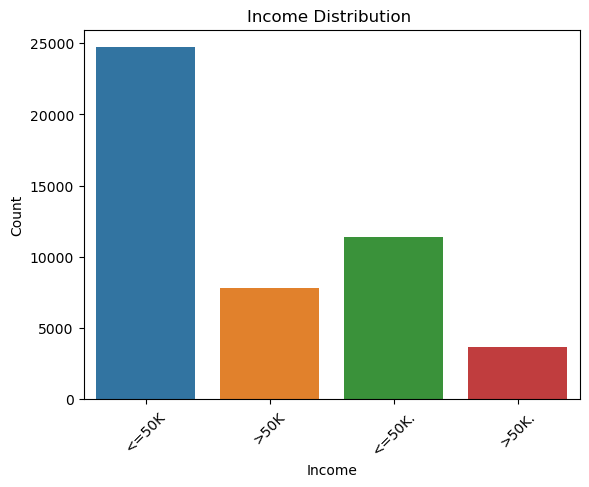

In [15]:
## Distribution of income
sns.countplot(x=df['income'], data=df)
plt.title('Income Distribution ')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.show()

We can see that there is an issue with the Income data. So we will do a bit of cleaning.

In [16]:

df['income'] = df['income'].replace(['<=50K.', '>50K.'], ['<=50K','>50K'])
df['income'].value_counts()

income
<=50K    36080
>50K     11541
Name: count, dtype: int64

In [30]:
#df['income'] = pd.to_numeric(df['income'], errors='coerce')


### Data Visualizations

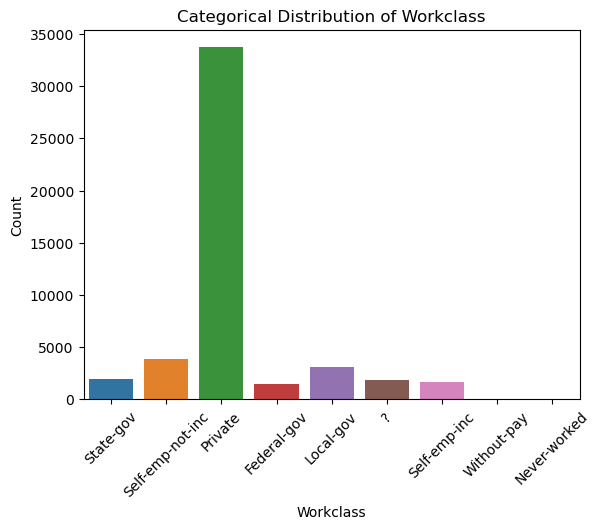

In [18]:
sns.countplot(x=df['workclass'], data=df)
plt.title('Categorical Distribution of Workclass')
plt.xlabel('Workclass')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

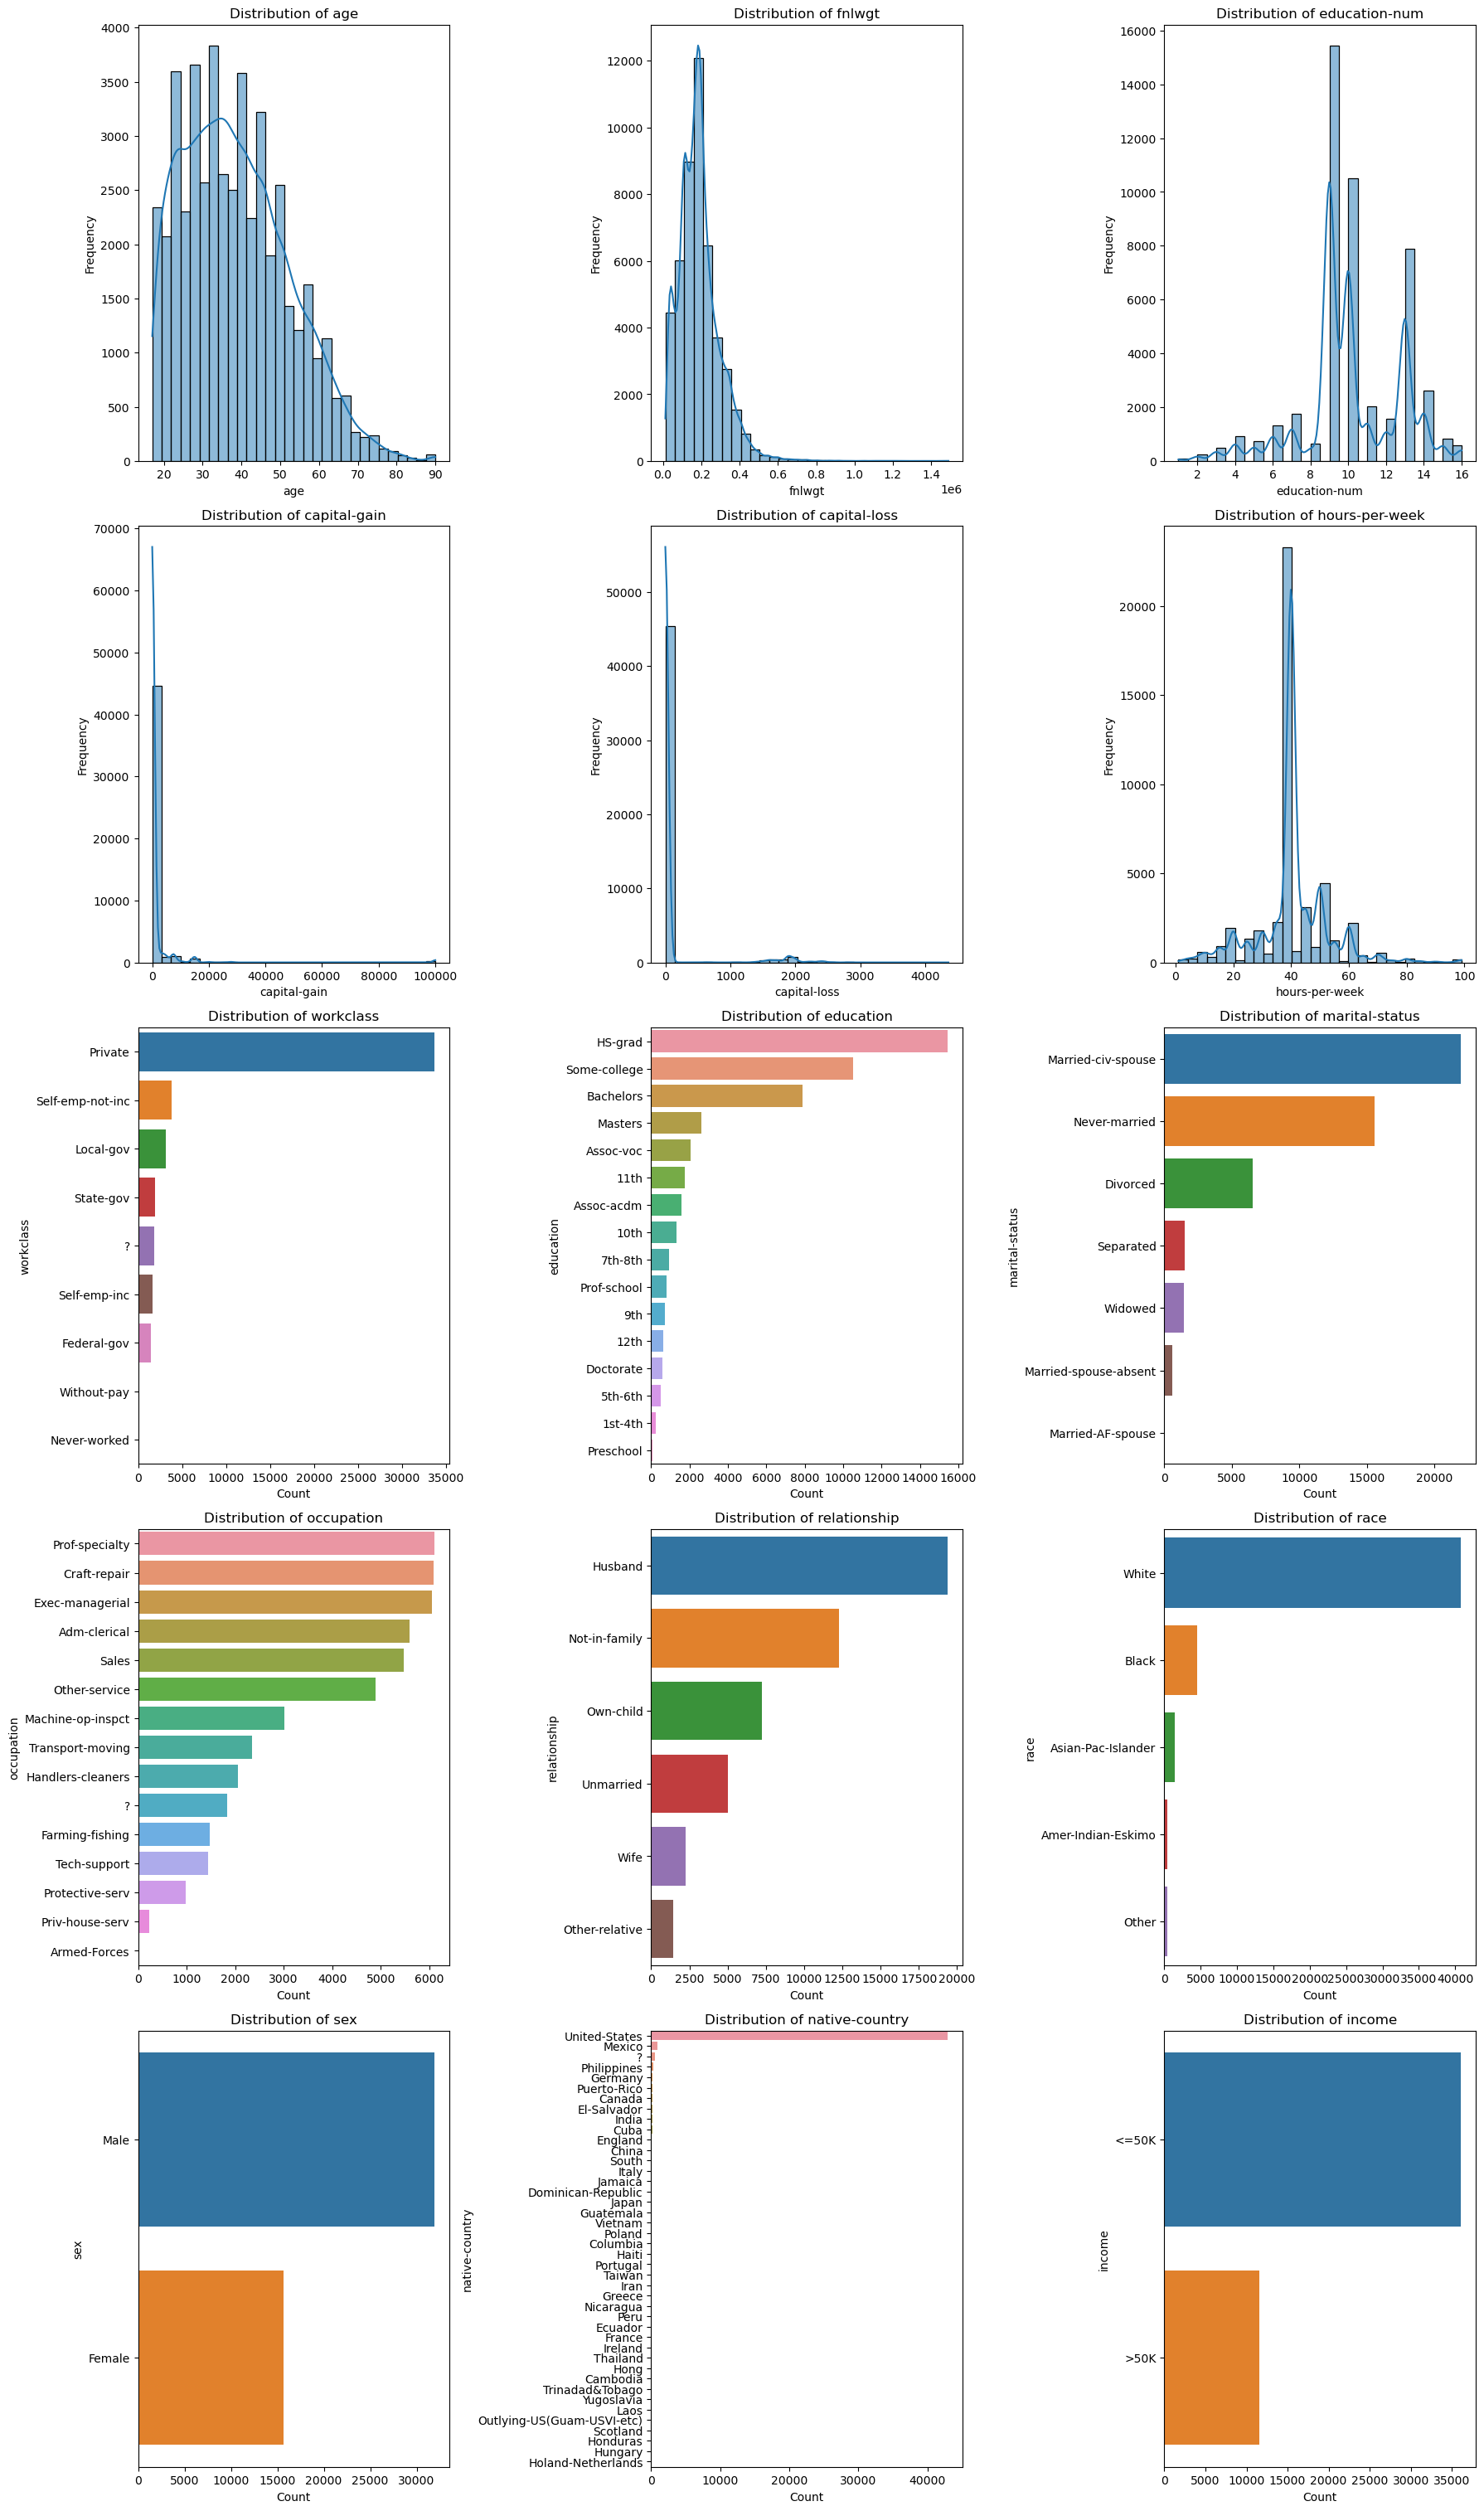

In [19]:


#Defining columns by data type
numerical_columns = df.select_dtypes(include=['int64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Create subplots
num_plots = len(numerical_columns) + len(categorical_columns)
cols = 3
rows = (num_plots // cols) + 1

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

# Plot numerical columns
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Plot categorical columns
for i, col in enumerate(categorical_columns, start=len(numerical_columns)):
    sns.countplot(y=df[col], ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Count')
    axes[i].set_ylabel(col)

# Remove any unused subplots
for i in range(len(numerical_columns) + len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


In [20]:
# check for Data shape
df.shape

(47621, 15)

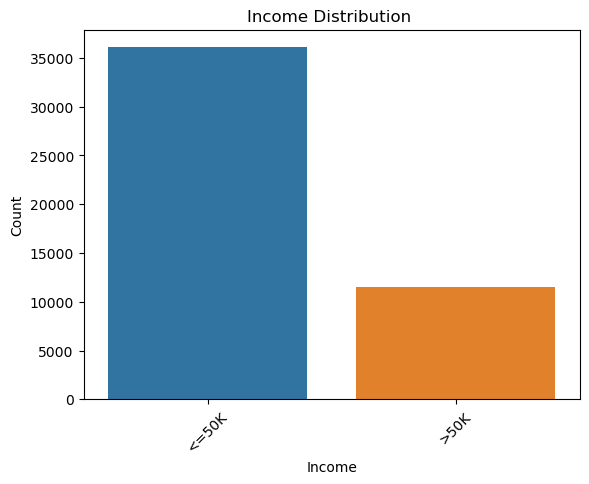

In [21]:
## Distribution of income
sns.countplot(x=df['income'], data=df)
plt.title('Income Distribution ')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.show()

In [22]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

### Encoding Categorical variables


In [25]:
from sklearn.preprocessing import LabelEncoder

#inititallizing label encoder
label_encoder = LabelEncoder()

def encode_categorical_columns(df):
    # Get the list of categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()
    
    # Encode categorical columns with numerical values
    for col in categorical_cols:
        df[col] = label_encoder.fit_transform(df[col])
    
    return df




In [26]:
new_df = encode_categorical_columns(df)
new_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


#### Split Features and target

In [27]:
features = new_df.iloc[:, :-1]
target = new_df['income']



In [35]:
X= features
y= target

### Scaling  features 

In [36]:
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(features)
X = pd.DataFrame(scaled_X, columns = features.columns)
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,0.875,0.044131,0.600000,0.800000,0.666667,0.071429,0.2,1.0,1.0,0.02174,0.0,0.397959,0.951220
1,0.452055,0.750,0.048052,0.600000,0.800000,0.333333,0.285714,0.0,1.0,1.0,0.00000,0.0,0.122449,0.951220
2,0.287671,0.500,0.137581,0.733333,0.533333,0.000000,0.428571,0.2,1.0,1.0,0.00000,0.0,0.397959,0.951220
3,0.493151,0.500,0.150486,0.066667,0.400000,0.333333,0.428571,0.0,0.5,1.0,0.00000,0.0,0.397959,0.951220
4,0.150685,0.500,0.220635,0.600000,0.800000,0.333333,0.714286,1.0,0.5,0.0,0.00000,0.0,0.397959,0.121951


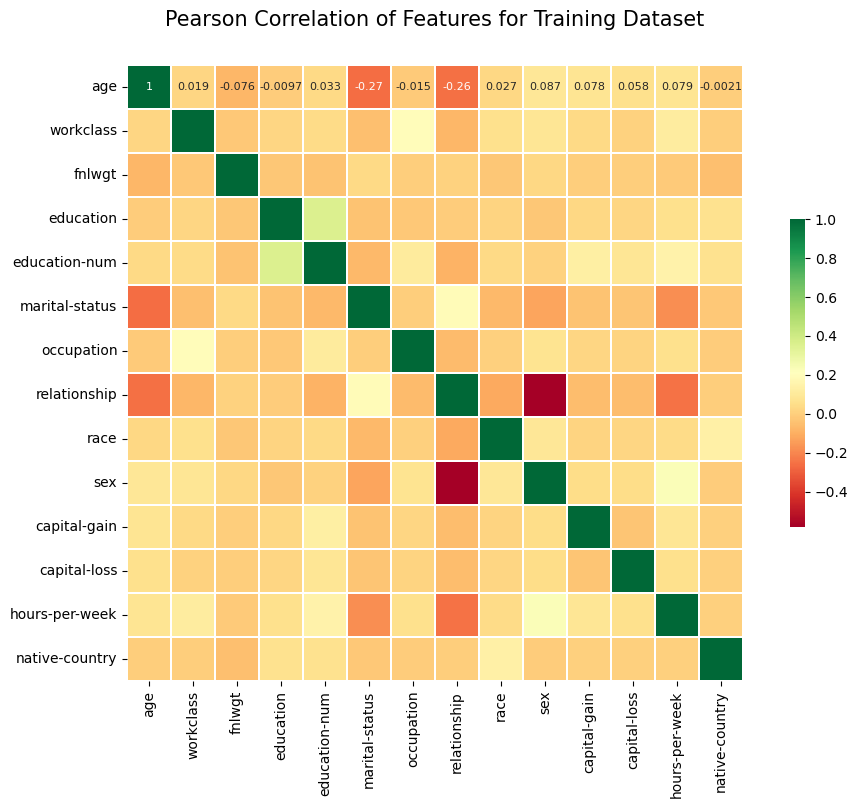

In [37]:
#correlation heatmap of dataset
def correlation_heatmap(new_df):
    _ , ax = plt.subplots(figsize =(12, 8))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        new_df.corr(), 
        cmap = "RdYlGn",
        square=True, 
        cbar_kws={'shrink':.5 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':8 }
    )
    
    plt.title('Pearson Correlation of Features for Training Dataset', y=1.05, size=15)

correlation_heatmap(X)

In [40]:
## Split into test and train
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state = 42)


In [41]:
from xgboost import XGBClassifier

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.75%


In [42]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6754  416]
 [ 846 1509]]


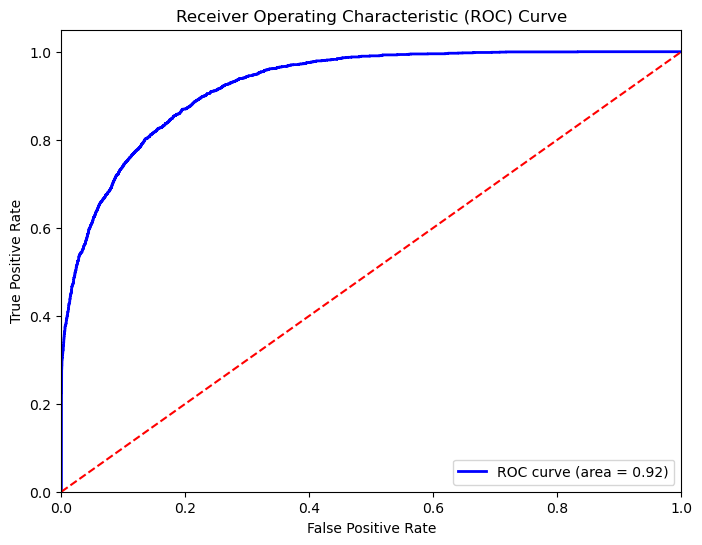

In [44]:
# ROC Curve

from sklearn.metrics import roc_curve

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<Axes: >

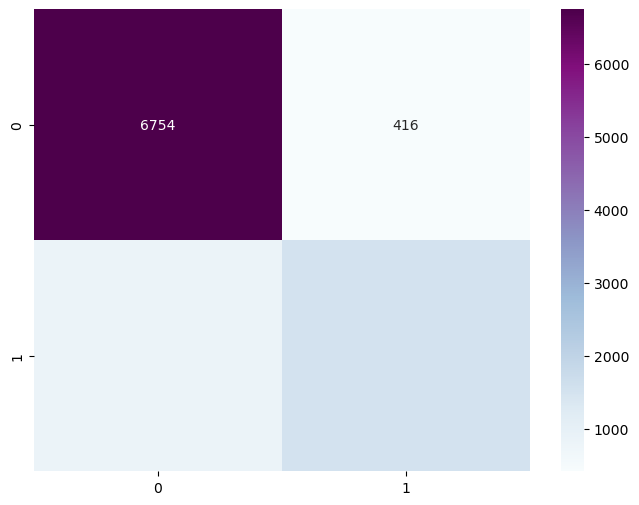

In [55]:
#confusion_matrix = pd.crosstab(pred, y_test, rownames= ['Predicted'], colnames=['Actual'])
plt.figure(figsize=(8, 6))  

confusion_matrix = pd.crosstab( y_test,y_pred, rownames= ['Actual'], colnames=['Predicted'])
#sns.heatmap(confusion_matrix, annot= True, cmap='BuPu', fmt='g')
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g', annot_kws={"fontsize":10}) # Adjust fontsize


In [56]:

# Classification Report with label names
target_names =['<=50k', '>50k']
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

       <=50k       0.89      0.94      0.91      7170
        >50k       0.78      0.64      0.71      2355

    accuracy                           0.87      9525
   macro avg       0.84      0.79      0.81      9525
weighted avg       0.86      0.87      0.86      9525



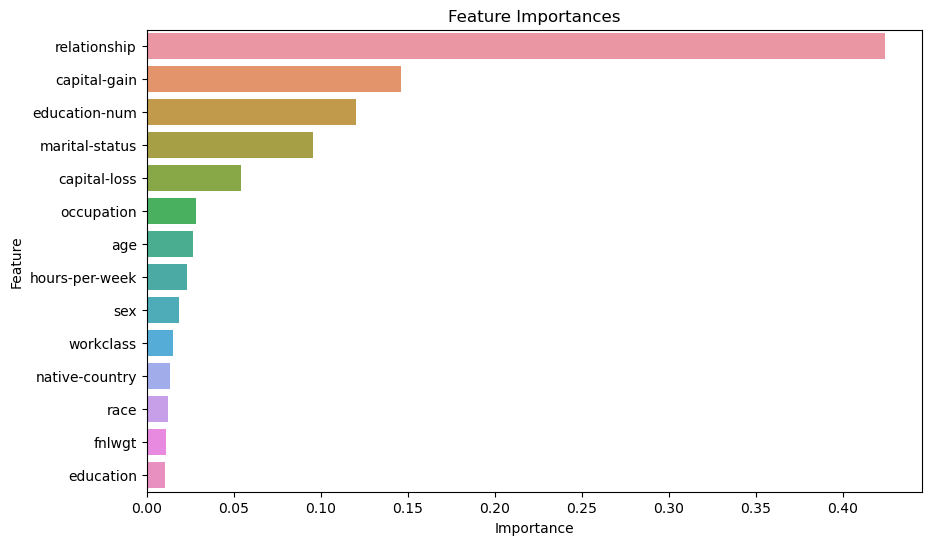

In [57]:
# Get feature importances
feature_importances = model.feature_importances_

# Create DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort feature importances in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


### Trying logistic Regression

In [61]:
# Define the hyperparameter grid for logistic regression
from sklearn.metrics import confusion_matrix
param_grid = {'C': [0.1, 0.5, 1, 5, 10],
              'penalty': ['l1', 'l2'],
              'solver': ['liblinear', 'saga'],
              'max_iter': [100, 500, 1000]}

# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Now I train a logistic regression model with the best hyperparameters
log_model = grid_search.best_estimator_
log_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
confusion_m = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f'Best hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Confusion matrix: \n{confusion}')
print(f'ROC AUC score: {roc_auc}')

Best hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Accuracy: 0.8222572178477691


NameError: name 'confusion' is not defined

In [62]:
print(f'Confusion matrix: \n{confusion_m}')
print(f'ROC AUC score: {roc_auc}')

Confusion matrix: 
[[6773  397]
 [1296 1059]]
ROC AUC score: 0.8537885504298104


In [63]:
log_model

LogisticRegression(C=10, penalty='l1', random_state=42, solver='saga')

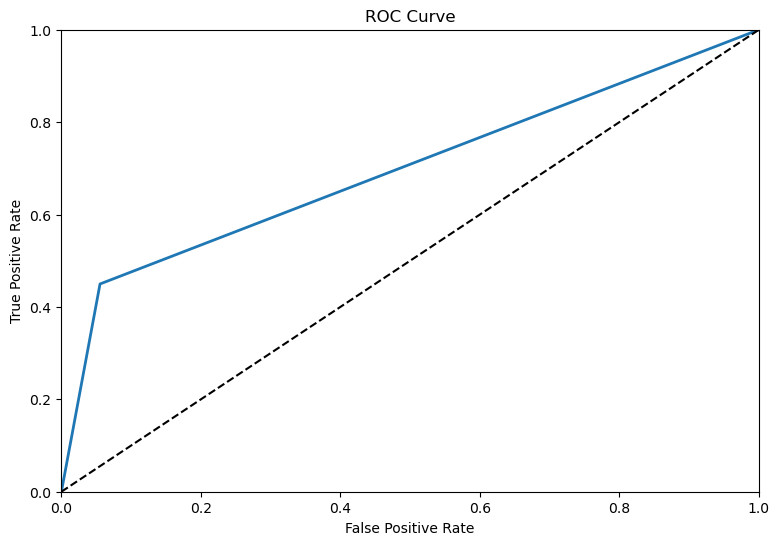

In [64]:
from sklearn.metrics import roc_curve


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')

fpr, tpr, thresholds = roc_curve(y_test, log_model.predict(X_test))
plt.figure(figsize=(9,6)); 
plot_roc_curve(fpr, tpr)
plt.show();


In [65]:


# Get feature coefficients
coefficients = log_model.coef_[0]

# Get absolute feature coefficients
abs_coefficients = np.abs(coefficients)

# Map feature names to feature coefficients
feature_names = X_train.columns
feature_coefficients_map = dict(zip(feature_names, abs_coefficients))

# Sort feature coefficients in descending order
sorted_feature_coefficients = sorted(feature_coefficients_map.items(), key=lambda x: x[1], reverse=True)

# Print most important features
print("Most Important Features:")
for feature, coefficient in sorted_feature_coefficients:
    print(f"{feature}: {coefficient}")


Most Important Features:
capital-gain: 31.870393859284693
education-num: 4.943775509313797
capital-loss: 2.9468134299839566
hours-per-week: 2.7810865108189415
age: 2.392895977397938
marital-status: 1.3746769665370007
sex: 0.8527681110840359
fnlwgt: 0.8061242936685846
relationship: 0.6980772119066126
race: 0.4703793064233019
workclass: 0.36873542613621285
education: 0.22352219612356133
occupation: 0.12333212814487084
native-country: 0.03929034556213272


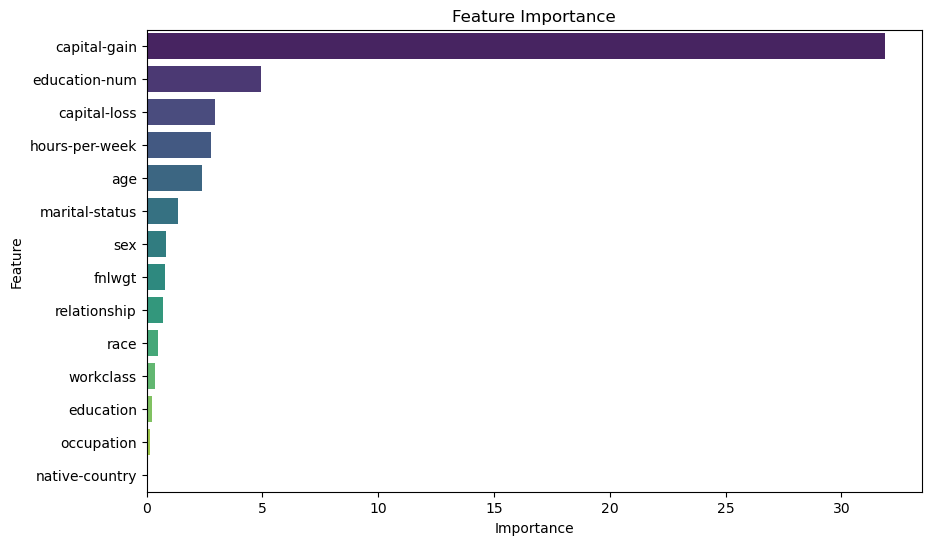

In [66]:
# Get absolute feature coefficients
abs_coefficients = np.abs(coefficients)

# Create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': abs_coefficients})

# Sort feature importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()